Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
0        8212
1        8215
2        8216
3        8217
4        8218
        ...  
8031    19860
8032    19863
8033    19864
8034    19865
8035    19866
Name: Date_numeric, Length: 8036, dtype: int64
Зашумленные столбцы: []
Смещение: Open             1.086680
High             1.086383
Low              1.087102
Close            1.086685
Adj Close        1.213587
Volume          13.602510
Date_numeric     0.000505
dtype: float64
Сильно смещенные столбцы: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Выбросы в столбце 'Open':
Series([], Name: Open, dtype: float64)

Выбросы в столбце 'High':
Series([], Name: High, dtype: float64)

Выбросы в столбце 'Low':
Series([], Name: Low, dtype: float64)

Выбросы в столбце 'Close':
Series([], Name: Close, dtype: float64)

Выбросы в столбце 'Adj Close':
7321    114.799438
7322    117.926170
7323    118.010414
7324    117.982330
7325    114.593483
7326    1

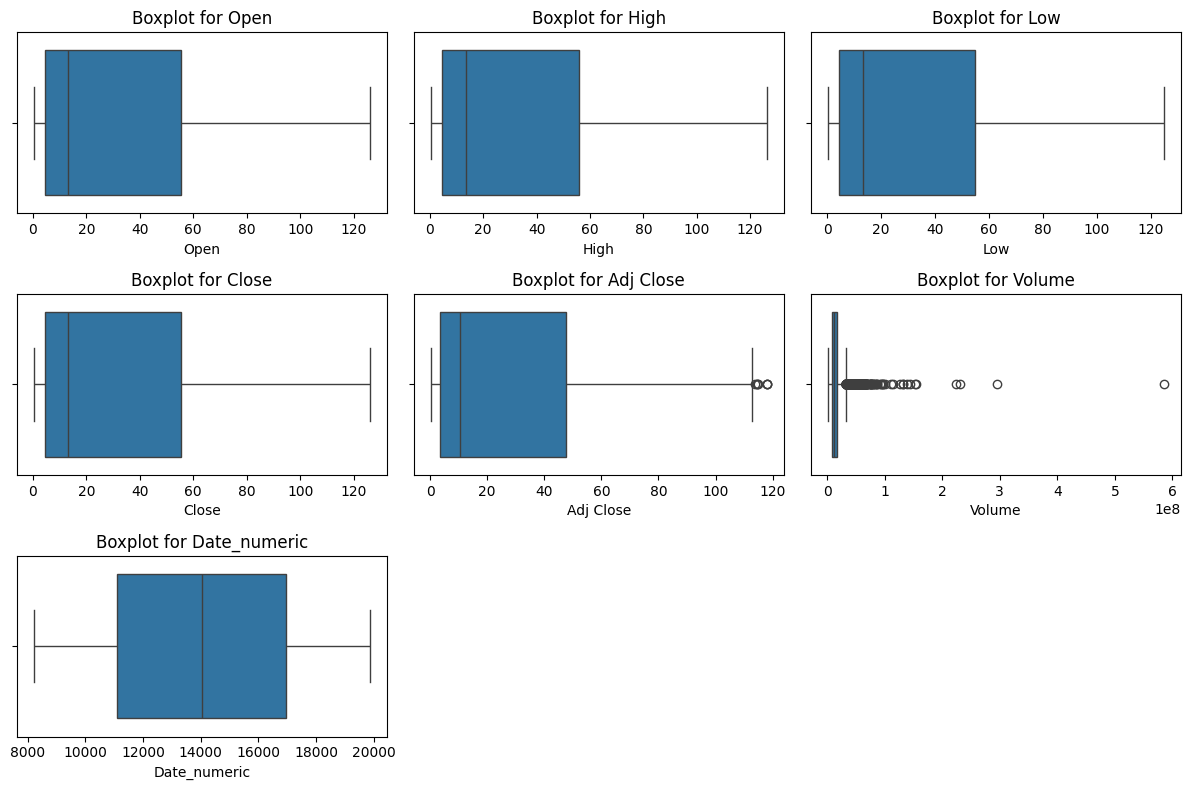

Просачивание данных: Высокая корреляция (1.00) между столбцами 'Date' и 'Date_numeric'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'Open' и 'High'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'Open' и 'Low'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'Open' и 'Close'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'Open' и 'Adj Close'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'High' и 'Open'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'High' и 'Low'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'High' и 'Close'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'High' и 'Adj Close'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'Low' и 'Open'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'Low' и 'High'
Просачивание данных: Высокая корреляция (1.00) между столбцами 'Low' и 'Close'
Просачивание данных: Высокая корреля

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/Coffe.csv")
print(df.columns)

df['Date'] = pd.to_datetime(df['Date'])
df['Date_numeric'] = (df['Date'] - pd.Timestamp('1970-01-01')).dt.days
print(df['Date_numeric'])

noisy_features = []
for col in df.columns:
  if df[col].isnull().sum() / len(df) > 0.1: 
    noisy_features.append(col)
print(f"Зашумленные столбцы: {noisy_features}")
 
skewness = df.select_dtypes(include=[np.number]).skew()
print(f"Смещение: {skewness}")

skewed_features = skewness[abs(skewness) > 1].index.tolist()
print(f"Сильно смещенные столбцы: {skewed_features}")

for col in df.select_dtypes(include=['number']).columns:
    if col == 'id':
        continue
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Выбросы в столбце '{col}':\n{outliers}\n")

numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col != 'id']

plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i) 
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

if len(df.columns) >= 2:
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                correlation = df[col1].corr(df[col2])
                if abs(correlation) > 0.9:
                    print(f"Просачивание данных: Высокая корреляция ({correlation:.2f}) между столбцами '{col1}' и '{col2}'")

df['log_close'] = np.log(df['Close'] + 1)
df['log_volume'] = np.log(df['Volume'] + 1)

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input 
    y = df_input[
        [stratify_colname]
    ]  

    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

bins = [df['Close'].min(), df['Close'].quantile(0.33), df['Close'].quantile(0.66), df['Close'].max()]
labels = ['Low', 'Medium', 'High']
df['Close_binned'] = pd.cut(df['Close'], bins=bins, labels=labels)
df = df.dropna()
# Now stratify using the binned values
df_train, df_val, df_test = split_stratified_into_train_val_test(
    df, stratify_colname="Close_binned", frac_train=0.60, frac_val=0.20, frac_test=0.20
)

print(df_train.columns) 
   
print("Обучающая выборка: ", df_train.shape)
print(df_train.Close.value_counts()) 

print("Контрольная выборка: ", df_val.shape)
print(df_val.Close.value_counts())

print("Тестовая выборка: ", df_test.shape)
print(df_test.Close.value_counts())

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_train, df_train["Close_binned"])
df_train_rus = pd.DataFrame(X_resampled)
print("Обучающая выборка после undersampling: ", df_train_rus.shape)
print(df_train_rus.Close.value_counts())
